<a href="https://colab.research.google.com/github/YinYinTan/CIND820FinalProject/blob/main/5_SVM_Classification_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machine Classification Models

In [2]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import time

In [3]:
#Read file
df = pd.read_csv('3a. Working Dataset.csv', index_col=None)

# 1. All Features in Working Dataset - Evaluation using Train-Test Split

In [ ]:
#Split dataframe, using 80% for training and 20% for testing
from sklearn.model_selection import train_test_split

X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

In [ ]:
#Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
smote = SMOTE(random_state = 888)
X_train, y_train = smote.fit_resample(X_train, y_train)

#SVM classification model

t1 = time.perf_counter() #time counter start

model = svm.SVC(random_state=888)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

t2 = time.perf_counter() #time counter ends

#Save results into dictionary
svm_all_base = {'Accuracy':metrics.accuracy_score(y_test, y_pred), 'Precision':metrics.precision_score(y_test, y_pred),'Recall':metrics.recall_score(y_test, y_pred),\
          'F1-Score':metrics.f1_score(y_test, y_pred),'AUC':metrics.roc_auc_score(y_test, y_pred),'Brier Score':metrics.brier_score_loss(y_test, y_pred),'Execution Time (sec)':int(t2-t1)}

#Evaluation of random forest classification model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))
print('Execution time in seconds:', int(t2-t1))

Accuracy: 0.7673210161662818
Precision: 0.8378956372968349
Recall: 0.8210393964794636
F1-score: 0.8293818797629128
Area Under Curve (AUC): 0.734731201022663
Brier Score: 0.23267898383371824
Execution time in seconds: 22


# 2. All Features in Working Dataset - Hyperparameter Tuning
In this section, a grid of hyperparameter ranges will be defined, and where k-fold cross validation will be performed with all combinations.

In [ ]:
from pprint import pprint

#Look at parameters currently used by the model
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 888,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


The following set of hyperparameters will be adjusted to narrow down the best combination of parameters:
*   C = Regularization parameter of the error term. The C value adds a penalty each time an item is misclassified. Thus, a low C value has more misclassified items, while a large C value has a plane with a very little margin that leads to overfitting.
*   gamma = Coefficient of the RBF kernel. A non-linear kernel like the RBF kernel uses a gamma value. It determines the influence of training points on the decision boundary. If the gamma value is low, all training points have an influence on the decision line, and the radius of similarity is high. If the gamma value is high, the radius of similarity is low and influence is limited only to the nearby points. A larger gamma value, therefore, results in overfitting.

In [ ]:
from sklearn.model_selection import GridSearchCV

#Create the parameter grid. This will try out 5 * 5 = 25 combinations of settings.
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
}

#Create the base model to tune
model = svm.SVC(random_state=888)

#Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, scoring = 'recall', n_jobs = -1, verbose = 2)

#Fit the grid search model
grid_search.fit(X_train, y_train)

#View the best parameters from fitting the grid search (based on model with the best recall)
grid_search.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


{'C': 1, 'gamma': 1}

In [ ]:
#Evaluate performance of best model from grid search
best = grid_search.best_estimator_
y_pred=best.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))

Accuracy: 0.6885103926096998
Precision: 0.6894752102058568
Recall: 0.9966471081307627
F1-score: 0.8150814053127677
Area Under Curve (AUC): 0.5015703073121346
Brier Score: 0.31148960739030024


Compared to the default SVC parameters used in the prior "All Features in Working Dataset - Evaluation using Train-Test Split" section, the best model from the grid search resulted in an 18% increase in Recall (the metric chosen for scoring).
*   However, performance reduced for all other metrics. AUC was 23% lower, followed by Precision (15%), Accuracy and Brier Score (8%), and F1-score (1%).

The best model found in the grid search has the same values for C as the default model (i.e. C = 1). Thus, the only parameter "tuned" was gamma.

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[   7 1071]
 [   8 2378]]


# 3. All Features in Working Dataset, Using Parameters from Grid Search - Evaluation using Repeated 10-fold Cross Validation

In [ ]:
X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

#Set cross-validation to 10-folds, repeated 3 times
folds = 10
repeats = 3
rkf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats, random_state=888)

#SVM classification model
model = svm.SVC(C=1, gamma=1, random_state=888)

#Performance metrics
accuracy = precision = recall = f1 = auc = brier = ex_time = 0

for train_index, test_index in rkf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE(random_state = 888)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  t1 = time.perf_counter() #time counter start

  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  t2 = time.perf_counter() #time counter ends

  accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
  precision = precision + metrics.precision_score(y_test, y_pred)
  recall = recall + metrics.recall_score(y_test, y_pred)
  f1 = f1 + metrics.f1_score(y_test, y_pred)
  auc = auc + metrics.roc_auc_score(y_test, y_pred)
  brier = brier + metrics.brier_score_loss(y_test, y_pred)
  ex_time = ex_time + t2-t1

#Save results into dictionary
svm_all_tuned = {'Accuracy':accuracy/(folds*repeats), 'Precision':precision/(folds*repeats),'Recall':recall/(folds*repeats),\
          'F1-Score':f1/(folds*repeats),'AUC':auc/(folds*repeats),'Brier Score':brier/(folds*repeats),'Execution Time (sec)':ex_time/(folds*repeats)}

#Evaluation of random forest classification model
print("Accuracy:", accuracy/(folds*repeats))
print("Precision:", precision/(folds*repeats))
print("Recall:", recall/(folds*repeats))
print("F1-score:", f1/(folds*repeats))
print("Area Under Curve (AUC):", auc/(folds*repeats))
print("Brier Score:", brier/(folds*repeats))
print('Execution time in seconds:', ex_time/(folds*repeats))

Accuracy: 0.6867217550362031
Precision: 0.6890722024539117
Recall: 0.9934334512846189
F1-score: 0.8137226958621465
Area Under Curve (AUC): 0.5006746724573992
Brier Score: 0.31327824496379697
Execution time in seconds: 128.38463339133335


# 4. Selected Features - Filter Method

## 4.1 Top 1 to 40 Features - Filter Method
SVM models were built using the top 1 to 40 features to compare performance.

In [ ]:
#Build classification model using 1 to 40 of the top features and compare performance on Recall

top_fourty = ['GEN_05', 'GEN_20', 'AGEDVG4', 'PPE_50E', 'PPE_50F', 'PPE_50C',
       'PPE_50D', 'PPE_50B', 'PPE_30C', 'PPE_50A', 'PPE_30F', 'PPE_30E',
       'ENVDVCON', 'PPE_30D', 'PPE_30H', 'PPE_40B', 'PPE_40A', 'PPE_30A',
       'PPE_45I', 'PPE_40D', 'EMPDVGOC_5', 'PPE_30G', 'ENVDVTYP_1', 'ENV_30',
       'PPE_40I', 'PPE_15C', 'PPE_15E', 'PPE_45A', 'EMPDVGOC_2', 'PPE_45B',
       'ENVDVTYP_3', 'PPE_30B', 'PPE_40F', 'PPE_15F', 'GEODVGPR_30', 'PPE_40H',
       'ENVDVGRW_30', 'EMP_10', 'ENVDVTYP_2', 'ENVDVTYP_6']

recall_test = []

for n in range(1, 41):
  #Obtain names of top n variables
  top = top_fourty[:n]

  #Split dataframe, using 80% for training and 20% for testing
  #Only select top n variables for X
  X = df[top]
  y = df['Worse_MH']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE(random_state = 888)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  #SVM classification model, using the parameters identified during hyperparameter tuning, except for max_features
  model = svm.SVC(C=3, gamma=1, random_state=888)
  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  #Save results into list
  recall_test.append(metrics.recall_score(y_test, y_pred))

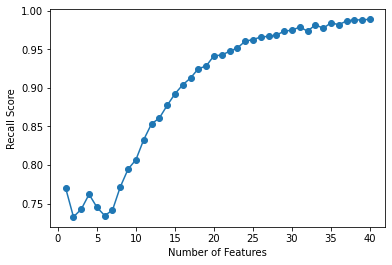

In [ ]:
#Plot recall scores against number of features used
plt.plot(range(1,41), recall_test, marker='o')
plt.ylabel('Recall Score')
plt.xlabel('Number of Features')
plt.show()

Based on the plot above, it appears that model performance is more unstable when less than 6 features are used, and then performance increases thereafter, tapering off when about 25 features are used.



## 4.2 Top 25 Features, Filter Method - Evaluation using Repeated 10-fold Cross Validation
Based on the results above, it was decided to build a SVM model using the top 25 features.

In [ ]:
#Obtain names of top 25 variables
top_25 = top_twenty[:25]
top_25

#Only select top 25 variables for X
X = df[top_25]
y = df['Worse_MH']

In [ ]:
#Set cross-validation to 10-folds, repeated 3 times
folds = 10
repeats = 3
rkf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats, random_state=888)

#SVM classification model, using the parameters identified during hyperparameter tuning, except for max_features
model = svm.SVC(C=3, gamma=1, random_state=888)

#Performance metrics
accuracy = precision = recall = f1 = auc = brier = ex_time = 0

for train_index, test_index in rkf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  #Apply Synthetic Mifilnority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE(random_state = 888)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  t1 = time.perf_counter() #time counter start

  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  t2 = time.perf_counter() #time counter ends

  accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
  precision = precision + metrics.precision_score(y_test, y_pred)
  recall = recall + metrics.recall_score(y_test, y_pred)
  f1 = f1 + metrics.f1_score(y_test, y_pred)
  auc = auc + metrics.roc_auc_score(y_test, y_pred)
  brier = brier + metrics.brier_score_loss(y_test, y_pred)
  ex_time = ex_time + t2-t1

#Save results into dictionary
svm_25_features_tuned = {'Accuracy':accuracy/(folds*repeats), 'Precision':precision/(folds*repeats),'Recall':recall/(folds*repeats),\
          'F1-Score':f1/(folds*repeats),'AUC':auc/(folds*repeats),'Brier Score':brier/(folds*repeats),'Execution Time (sec)':ex_time/(folds*repeats)}

#Evaluation of random forest classification model
print("Accuracy:", accuracy/(folds*repeats))
print("Precision:", precision/(folds*repeats))
print("Recall:", recall/(folds*repeats))
print("F1-score:", f1/(folds*repeats))
print("Area Under Curve (AUC):", auc/(folds*repeats))
print("Brier Score:", brier/(folds*repeats))
print('Execution time in seconds:', ex_time/(folds*repeats))

Accuracy: 0.6849896867741216
Precision: 0.6969590046185302
Recall: 0.9601253630893112
F1-score: 0.8076392732902326
Area Under Curve (AUC): 0.5180960767209078
Brier Score: 0.3150103132258783
Execution time in seconds: 108.36433808370033


# 5. Comparison of Models

In [ ]:
#Combine performance metrics for all models into one dataframe
comparison = pd.DataFrame([svm_all_base, svm_all_tuned, svm_25_features_tuned], index=['SVM All Features - Base','SVM All Features - Tuned','SVM 25 Features - Tuned'])
comparison

,Accuracy,Precision,Recall,F1-Score,AUC,Brier Score,Execution Time (sec)
SVM All Features - Base,0.767321,0.837896,0.821039,0.829382,0.734731,0.232679,22.000000
SVM All Features - Tuned,0.686722,0.689072,0.993433,0.813723,0.500675,0.313278,128.384633
SVM 25 Features - Tuned,0.684990,0.696959,0.960125,0.807639,0.518096,0.315010,108.364338


'SVM All Features - Tuned', the SVM model using all features and the parameters identified during hyperparameter tuning, had the best Recall with a reasonable execution time of 128 seconds.

# 6. Stability of Best Model by Varying k-folds for Cross Validation

The stability of the best model identified above was tested by performing repeated k-folds cross-validation, with values of k from 5 to 12.
*   Originally, values of k from 3 to 15 were used, but execution runtime exceeded 10 hours before the decision was made to interrupt execution. Values of k were then changed to reduce runtime.



In [4]:
X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

In [ ]:
recall_test = []

for k in range(5, 13):
  #Set cross-validation to k-folds, repeated 3 times
  repeats = 3
  rkf = RepeatedStratifiedKFold(n_splits=k, n_repeats=3, random_state=888)

  #Best SVM classification model identified in section 5, 'SVM All Features - Tuned'
  model = svm.SVC(C=1, gamma=1, random_state=888)

  #Performance metrics
  recall = 0

  for train_index, test_index in rkf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
    smote = SMOTE(random_state = 888)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)

    recall = recall + metrics.recall_score(y_test, y_pred)

  #Calculate average recall, append to list
  recall_test.append(recall/(k*repeats))

#Plot recall scores against number of features used
plt.plot(range(5, 13), recall_test, marker='o')
plt.ylabel('Recall Score')
plt.xlabel('Number of Folds')
plt.show()

print("Range of Recall Scores (percent):", (max(recall_test)-min(recall_test))*100)

The model appears to be quite stable, with Recall ranging by less than 1%.